# Exploratory Data Analysis for the QM9 Dataset

To get a feel for the dataset, it is helpful to start by visualising both the molecular graphs as well as the distribution of properties (like HOMO-LUMO). We can also visualise correlations between different properties to identify which targets might be most helpful, but since this is a toy project, we will skip this for now.

In [3]:
import torch_geometric as pyg
from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader
import mygenai
from rdkit import Chem
from IPython.display import SVG

# using the QM9 dataset, as it includes quantum properties and is of modest size
dataset = QM9(root="../data/QM9")

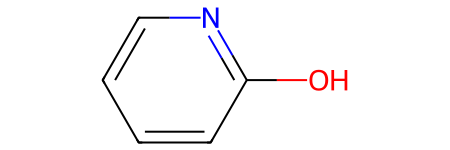

In [4]:
m = Chem.MolFromSmiles('c1cccnc1O')
SVG(mygenai.utils.moltosvg(m))